# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных:

**Данные геологоразведки трёх регионов находятся в файлах:**

* d — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

# Условия задачи:

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [107]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [108]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [109]:
temp = df_1.copy()
list_c = [
    'id', 'f0', 'f1', 'f2']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l, temp[col_l].value_counts())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-------------------------
id ['006OJ' '009eY' '00AfQ' ... 'zztWK' 'zzyhQ' 'zzzLH']
id A5aEY    2
Tdehs    2
QcMuo    2
fiKDv    2
bxg6G    2
        ..
GrP0O    1
NHtAG    1
nH4jP    1
jKe1Q    1
e6e2a    1
Name: id, Length: 99990, dtype: int64
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 [-1.40860531 -1.35177299 -1.30222711 ...  2.33375269  2.33707957
  2.36233081]
f0 -1.218900    1
 0.407085    1
 1.162604    1
 0.886105    1
 0.031749    1
            ..
 0.425951    1
 0.900468    1
 0.865040    1
-0.126201    1
 1.751793    1
Na

In [110]:
temp = df_2.copy()
list_c = [
    'id', 'f0', 'f1', 'f2']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l, temp[col_l].value_counts())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-------------------------
id ['0022J' '003Gl' '003Vx' ... 'zzv4E' 'zzy2c' 'zzzvI']
id LHZR0    2
bfPNe    2
5ltQ6    2
wt4Uk    2
QVhNM    1
        ..
Yr1CE    1
4NJjj    1
YSQof    1
7v3bp    1
LfGSL    1
Name: id, Length: 99996, dtype: int64
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 [-31.60957602 -27.82961614 -26.64625507 ...  28.93082879  29.25906208
  29.42175461]
f0  9.471578     1
 17.560369    1
 20.515576    1
 4.648343     1
 8.195679     1
             ..
-8.003850     1
 14.444814    1
-9.439604     1
 4.966853     1
 

In [111]:
temp = df_3.copy()
list_c = [
    'id', 'f0', 'f1', 'f2']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l, temp[col_l].value_counts())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
-------------------------
id ['009Gl' '00AuD' '00CaL' ... 'zzqqy' 'zzsKd' 'zzz9h']
id xCHr8    2
KUPhW    2
VF7Jo    2
Vcm5J    2
ql5l5    1
        ..
F7ueb    1
51bMq    1
eWcKs    1
EQj8O    1
FWbqp    1
Name: id, Length: 99996, dtype: int64
id : кол-во NaN 0 , процент NaN 0.0 %
-------------------------
f0 [-8.76000362 -7.45058711 -7.18949804 ...  7.19461485  7.21552717
  7.23826248]
f0  1.936057    1
-0.784222    1
-2.351132    1
 0.075698    1
 2.018140    1
            ..
 1.839556    1
 0.754413    1
-0.401612    1
-2.771517    1
-0.107381    1
Na

В столбце id присутствуют дубликаты, посмотрим на них.

In [112]:
df_1[df_1['id'] == 'QcMuo']

,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


In [113]:
df_2[df_2['id'] == 'LHZR0']

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


In [114]:
df_3[df_3['id'] == 'VF7Jo']

,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


В данных присутсвуют одинаковые id но сразными данными, выглядят они очень cтранно, но так как их мало, думаю можно просто их удалить.


In [115]:
def clear_duplicat(df):
    names = df['id'].value_counts().reset_index()
    unique_names = names.query('id == 1')['index'].to_list()
    df.query('id in @unique_names', inplace=True)

In [116]:
clear_duplicat(df_1)
clear_duplicat(df_2) 
clear_duplicat(df_3)

In [117]:
print(df_1.shape)
print(df_2.shape) 
print(df_3.shape)

(99980, 5)
(99992, 5)
(99992, 5)


Посмотрим как данные коррелируют между собой.

<AxesSubplot:>

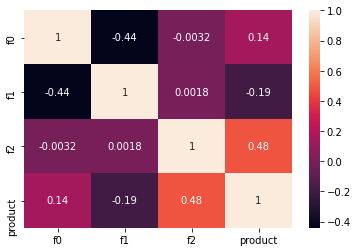

In [118]:
sns.heatmap(df_1.corr(), annot=True)

<AxesSubplot:>

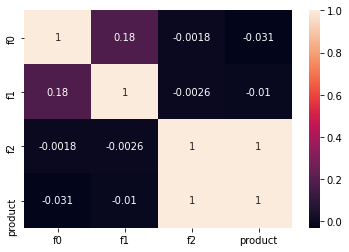

In [119]:
sns.heatmap(df_2.corr(), annot=True)

<AxesSubplot:>

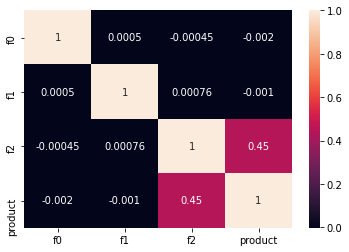

In [120]:
sns.heatmap(df_3.corr(), annot=True)

Из наблюдей можно сказать:

    * 1й и 3й регион немного схожи в том как f2 коррелирует с product
    * в целомрегионы обсалютно разные
    * сильнее всего признак product коррелирует с признаком f2
    * во 2ом регионее product и f2 сильно коррелируют

**Вывод**

* Изучили и общую информацию о данных
* Выявили и удалили дуюликаты в id
* Посморели как данные коррелируют между собой

## Обучение и проверка модели

In [121]:
def split(df):
    target = df['product']
    features = df.drop(['id', 'product'], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.25, random_state=1)
    model = LinearRegression()
    model.fit(features_train, target_train)
    return pd.Series(model.predict(features_valid)), target_valid

In [122]:
predict_1, target_1 = split(df_1)
predict_2, target_2 = split(df_2)
predict_3, target_3 = split(df_3)

In [123]:
def mean_product_rmse (targ, predictions):
    mse = mean_squared_error(targ, predictions)
    print('Средний запас сырья, тыс. баррелей:', predictions.mean())
    print('RMSE:', mse ** 0.5)

In [124]:
print('1й регион')
print()
mean_product_rmse(target_1, predict_1)

1й регион

Средний запас сырья, тыс. баррелей: 92.57117427399304
RMSE: 37.65164533744765


In [125]:
print('2й регион')
print()
mean_product_rmse(target_2, predict_2)

2й регион

Средний запас сырья, тыс. баррелей: 69.00877024308444
RMSE: 0.887112373864716


In [126]:
print('3й регион')
print()
mean_product_rmse(target_3, predict_3)

3й регион

Средний запас сырья, тыс. баррелей: 94.82610388045815
RMSE: 39.857517273558194


**Вывод:**

* Разбили данные на валидационную и обущающую выборки
* Обучили модель, сделали и сохранили предсказания для каждого региона.
* Посчитали средний запас сырья для каждого региона по предсказаниям и RMSE, качественнее всего модель отработала для 2го региона, здесь метрика RMSE с самым маленьким значением - наверняка так влияет большой коэффициент корреляции между одним из признаков и целевым признаком
* Средний предсказанный запас сырья больше всего у регионов 1 и 3, больше 90 тыс. бареллей. Здесь же значение RMSE получилось очень большим, почти половина этого числа

## Подготовка к расчёту прибыли

Из условия задачи возьмем, предоставленные значения

In [127]:
# Колличество скважин
borehole = 200 

# Бюджет на разработку скважин в регионе
budget = 10000000000

# Доход с каждой единицы продукта
revenue = 450000

# Вероятность убытков меньше чем 
probability_of_losses = 0.025

Посчитаем какой бюджет выделяеться на одну скважину в регионе.

In [128]:
budget_for_one_borehole = budget/borehole
budget_for_one_borehole

50000000.0

Посмотрим на минимально среднеее количества продукта необходимое для того что бы проект был прибыльным.

In [129]:
budget_for_one_borehole/revenue

111.11111111111111

In [130]:
print('Истинный средний запас сырья по регионам')
print()
print('1й регион', target_1.mean())
print('2й регион', target_2.mean())
print('3й регион', target_3.mean())

Истинный средний запас сырья по регионам

1й регион 92.32698630202161
2й регион 69.0110496797081
3й регион 94.77919925823326


Исходя из рассчетов, можно сделать вывод что не один регион не являтся прибыльным, но нам нужно только 500 скважин из которых выберется 200 лучших по прибольности.

In [131]:
def top_revenue(target, probabilites):
    target = pd.Series(target).reset_index(drop=True)
    probabilites = (pd.Series(probabilites).reset_index(drop=True)
                    .sort_values(ascending=False))
    select = target[probabilites.index][:borehole]
    return((revenue*select.sum())- budget)/1000000000

In [132]:
top_revenue(target_1, predict_1)

3.184038917684292

In [133]:
top_revenue(target_2, predict_2)

2.4150866966815108

In [134]:
top_revenue(target_3, predict_3)

2.3892174412256564

Из рассчетов видно что на данном этапе самым прибыльным получается 1й регион, доход более 3х млрд.

## Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона.

In [135]:
state = np.random.RandomState(777)

In [136]:
def bootstrap(target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        rev = top_revenue(target_subsample, probs_subsample)
        values.append(rev)

    values = pd.Series(values)
    lower = values.quantile(probability_of_losses)
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    mean = values.mean()

    print("Средняя выручка:", mean)
    print("2.5%-квантиль:", lower)
    print("Доверительный интервал:", confidence_interval)
    print("Доверительный интервал по квантилям:", (lower, upper))
    print("Риски убытка:", (values < 0).mean()*100)

In [137]:
bootstrap(target_1, predict_1)

Средняя выручка: 0.4264146645290173
2.5%-квантиль: -0.08362899806249957
Доверительный интервал: (0.4100348134133467, 0.44279451564468786)
Доверительный интервал по квантилям: (-0.08362899806249957, 0.95867923368282)
Риски убытка: 6.1


In [138]:
bootstrap(target_2, predict_2)

Средняя выручка: 0.4730207464497119
2.5%-квантиль: 0.05886060722922645
Доверительный интервал: (0.460192507915547, 0.48584898498387685)
Доверительный интервал по квантилям: (0.05886060722922645, 0.8779779849568642)
Риски убытка: 1.0


In [139]:
bootstrap(target_3, predict_3)

Средняя выручка: 0.3940791082745665
2.5%-квантиль: -0.14142354780635746
Доверительный интервал: (0.3773341228659733, 0.4108240936831597)
Доверительный интервал по квантилям: (-0.14142354780635746, 0.9216756400436849)
Риски убытка: 7.3


# Общий вывод:

Исходя из расчетов можно сделать вывод, что самый прибыльный регион 2й. Его показатели средней выручки и доверительного интервала выше чем у 1го и 3го региона, а риск уже наоборот меньше. 